# End-to-End Tutorial: Training a Neural Network with PyTorch and Xbatcher

This tutorial demonstrates how to use xarray, xbatcher, and PyTorch to train a simple neural network on the FashionMNIST dataset.

## Step 1: Setup 

Import the necessary libraries and load the dataset

In [17]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import xarray as xr

import xbatcher as xb
import xbatcher.loaders.torch

In [18]:
ds = xr.open_dataset(
    's3://carbonplan-share/xbatcher/fashion-mnist-train.zarr', engine='zarr', chunks={}
)
ds

<xarray.Dataset> Size: 189MB
Dimensions:  (sample: 60000, channel: 1, height: 28, width: 28)
Coordinates:
  * sample   (sample) int64 480kB 0 1 2 3 4 5 ... 59995 59996 59997 59998 59999
Dimensions without coordinates: channel, height, width
Data variables:
    images   (sample, channel, height, width) float32 188MB dask.array<chunksize=(7500, 1, 7, 7), meta=np.ndarray>
    labels   (sample) int64 480kB dask.array<chunksize=(30000,), meta=np.ndarray>

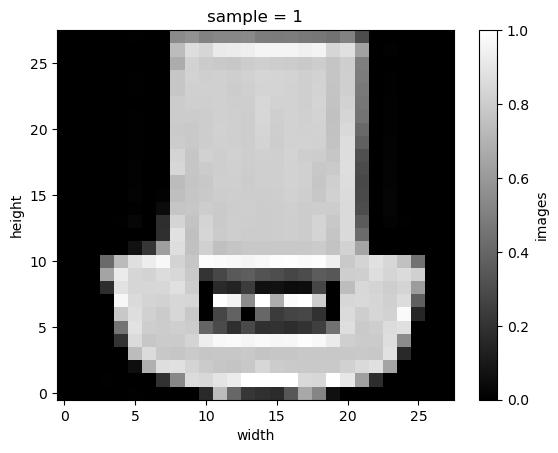

In [21]:
ds.sel(sample=1).images.plot(cmap='gray');

## Step 2: Create batch generator and data loader

We use `xbatcher` to create batch generators for the images (`X_bgen`) and labels (`y_gen`)

In [29]:
# Define batch generators
X_bgen = xb.BatchGenerator(
    ds['images'], input_dims={'sample': 2000, 'channel': 1, 'height': 28, 'width': 28}
)
y_bgen = xb.BatchGenerator(ds['labels'], input_dims={'sample': 2000})
X_bgen[0]

<xarray.DataArray 'images' (sample: 2000, channel: 1, height: 28, width: 28)> Size: 6MB
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
...
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)
Coordinates:
  * sample   (sample) int64 16kB 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
Dimensions without coordinates: channel, height, width

In [30]:
# Map batches to a PyTorch-compatible dataset
dataset = xbatcher.loaders.torch.MapDataset(X_bgen, y_bgen)

In [31]:
# Create a DataLoader
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=None)

In [12]:
train_features, train_labels = next(iter(train_dataloader))

Feature batch shape: torch.Size([1000, 1, 28, 28])
Labels batch shape: torch.Size([1000])


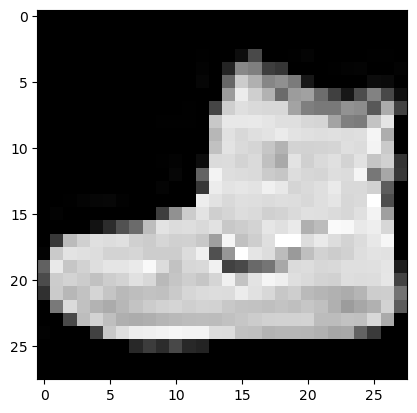

Label: 9


In [32]:
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f'Label: {label}')

## Step 3: Define the Neural Network

We define a simple feedforward neural network for classification.

In [33]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [35]:
# Instantiate the model
model = SimpleNN()
model

SimpleNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## Step 4: Define Loss Function and Optimizer
We use Cross-Entropy Loss and the Adam optimizer.

In [36]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

##  Step 5: Train the Model
We train the model using the data loader.

In [37]:
epochs = 5

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    for batch, (X, y) in enumerate(train_dataloader):
        # Forward pass
        predictions = model(X)
        loss = loss_fn(predictions, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            print(f'Batch {batch}: Loss = {loss.item():.4f}')

print('Training completed!')

Epoch 1/5
Batch 0: Loss = 2.2995
Batch 10: Loss = 1.3140
Batch 20: Loss = 0.8774
Epoch 2/5
Batch 0: Loss = 0.7481
Batch 10: Loss = 0.6749
Batch 20: Loss = 0.5963
Epoch 3/5
Batch 0: Loss = 0.5833
Batch 10: Loss = 0.5580
Batch 20: Loss = 0.5159
Epoch 4/5
Batch 0: Loss = 0.5141
Batch 10: Loss = 0.5027
Batch 20: Loss = 0.4751
Epoch 5/5
Batch 0: Loss = 0.4759
Batch 10: Loss = 0.4693
Batch 20: Loss = 0.4502
Training completed!


##  Step 6: Evaluate the Model
You can evaluate the model on the test set or visualize some predictions.

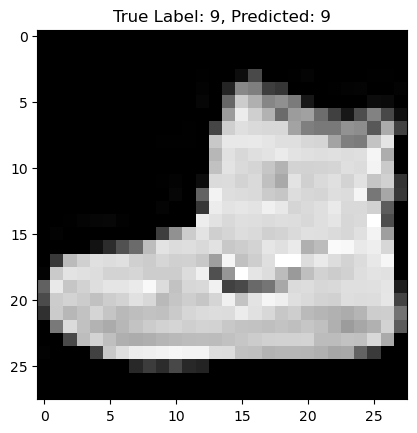

In [38]:
# Visualize a sample prediction
img = train_features[0].squeeze()
label = train_labels[0]
predicted_label = torch.argmax(model(train_features[0:1]), dim=1).item()

plt.imshow(img, cmap='gray')
plt.title(f'True Label: {label}, Predicted: {predicted_label}')
plt.show()

## Key Highlights

- **Data Handling**: We use Xbatcher to create efficient, chunked data pipelines from Xarray datasets.
- **Integration**: The `xbatcher.loaders.torch.MapDatase`t enables direct compatibility with PyTorch's DataLoader.
- **Training**: PyTorch simplifies the model training loop while leveraging the custom data pipeline.
